In [1]:
from multiprocessing import Pool

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd 

import CASBI 
import yaml
import time
import numpy as np
import pandas as pd
from multiprocessing import Pool
from multiprocessing import cpu_count

import ili
from ili.dataloaders import NumpyLoader, TorchLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.validation.metrics import PosteriorSamples
import tarp

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn


from sklearn.neighbors import NearestNeighbors

In [2]:
data = pd.read_parquet('/export/data/vgiusepp/data/full_dataframe/dataframe/dataframe.parquet')
feh_min, feh_max = data['feh'].min(), data['feh'].max()
ofe_min, ofe_max = data['ofe'].min(), data['ofe'].max()
data['star_log10mass'] = 10**data['star_log10mass']
data_mass = data['star_log10mass'].drop_duplicates()
data_mass = data_mass[data_mass<1.4*1e9]

m_min, m_max = data_mass.min(), data_mass.max()
alpha = 1.25

mass_name = data[['star_log10mass', 'Galaxy_name', 'infall_time']].drop_duplicates()
mass_name = mass_name[mass_name['star_log10mass']<6*1e9]
min_feh, max_feh = data['feh'].min(), data['feh'].max() 
min_ofe, max_ofe = data['ofe'].min(), data['ofe'].max()
mass_nn = mass_name['star_log10mass'].values.reshape(-1, 1)
infall_time = mass_name['infall_time'].values.reshape(-1, 1)
galaxy_name = mass_name['Galaxy_name'].values.reshape(-1, 1)

test_set_sample = 100
train_set_sample = 5_000

mass_nn = mass_name['star_log10mass'].values.reshape(-1, 1)
infall_time = mass_name['infall_time'].values.reshape(-1, 1)
galaxy_name = mass_name['Galaxy_name'].values.reshape(-1, 1)
# with Pool(processes=cpu_count()) as p:
#     result = p.starmap(gen_real_halo, [[j, galaxy_name, mass_nn, infall_time] for j in range(test_set_sample)]   )

# hist_list_test, params_list_test, galaxy_list_test = zip(*result)

unique_galaxy = data[['star_log10mass', 'infall_time', 'Galaxy_name']].drop_duplicates()

In [3]:
# Assuming unique_galaxy is your DataFrame
# Step 1: Bin both 'star_log10mass' and 'infall_time'
mass_bins = pd.qcut(unique_galaxy['star_log10mass'], 4, duplicates='drop')
time_bins = pd.qcut(unique_galaxy['infall_time'], 4, duplicates='drop')

# Add bin information as new columns
unique_galaxy['mass_bin'] = mass_bins
unique_galaxy['time_bin'] = time_bins

# Step 2: Sample galaxies
sampled_galaxies = []
for mass_bin in sorted(unique_galaxy['mass_bin'].unique()):
    for time_bin in sorted(unique_galaxy['time_bin'].unique()):
        bin_galaxies = unique_galaxy[(unique_galaxy['mass_bin'] == mass_bin) & (unique_galaxy['time_bin'] == time_bin)]
        if not bin_galaxies.empty:
            sampled_galaxy = bin_galaxies.sample(n=1)  # Sample one galaxy if available
            sampled_galaxies.append(sampled_galaxy)

# Concatenate sampled galaxies into a single DataFrame
sampled_df = pd.concat(sampled_galaxies).reset_index(drop=True)

# Step 3: Arrange the sampled galaxies in a 4x4 grid
# Sort by 'star_log10mass' and 'infall_time' to align with the grid arrangement
# sampled_df = sampled_df.sort_values(by=['star_log10mass', 'infall_time'])

# Reshape the DataFrame for a 4x4 grid representation
# Note: This step is for visualization and may need adjustment based on the actual number of samples available
grid_df = sampled_df[['Galaxy_name', 'star_log10mass', 'infall_time']].values.reshape(4, 4, 3)

# grid_df now represents the 4x4 grid with the desired properties
# Each element in grid_df is an array: [Galaxy_name, star_log10mass, infall_time]
# You can further process grid_df as needed for visualization or analysis

/tmp/ipykernel_3933606/3283589316.py:29: RuntimeWarning: divide by zero encountered in log10
  im = axs[i, j].imshow(np.log10(arr.T), origin='lower', vmin=np.log10(min_arr), vmax=np.log10(max_arr) , extent=[feh_min, feh_max, ofe_min, ofe_max], aspect='auto', cmap='viridis')


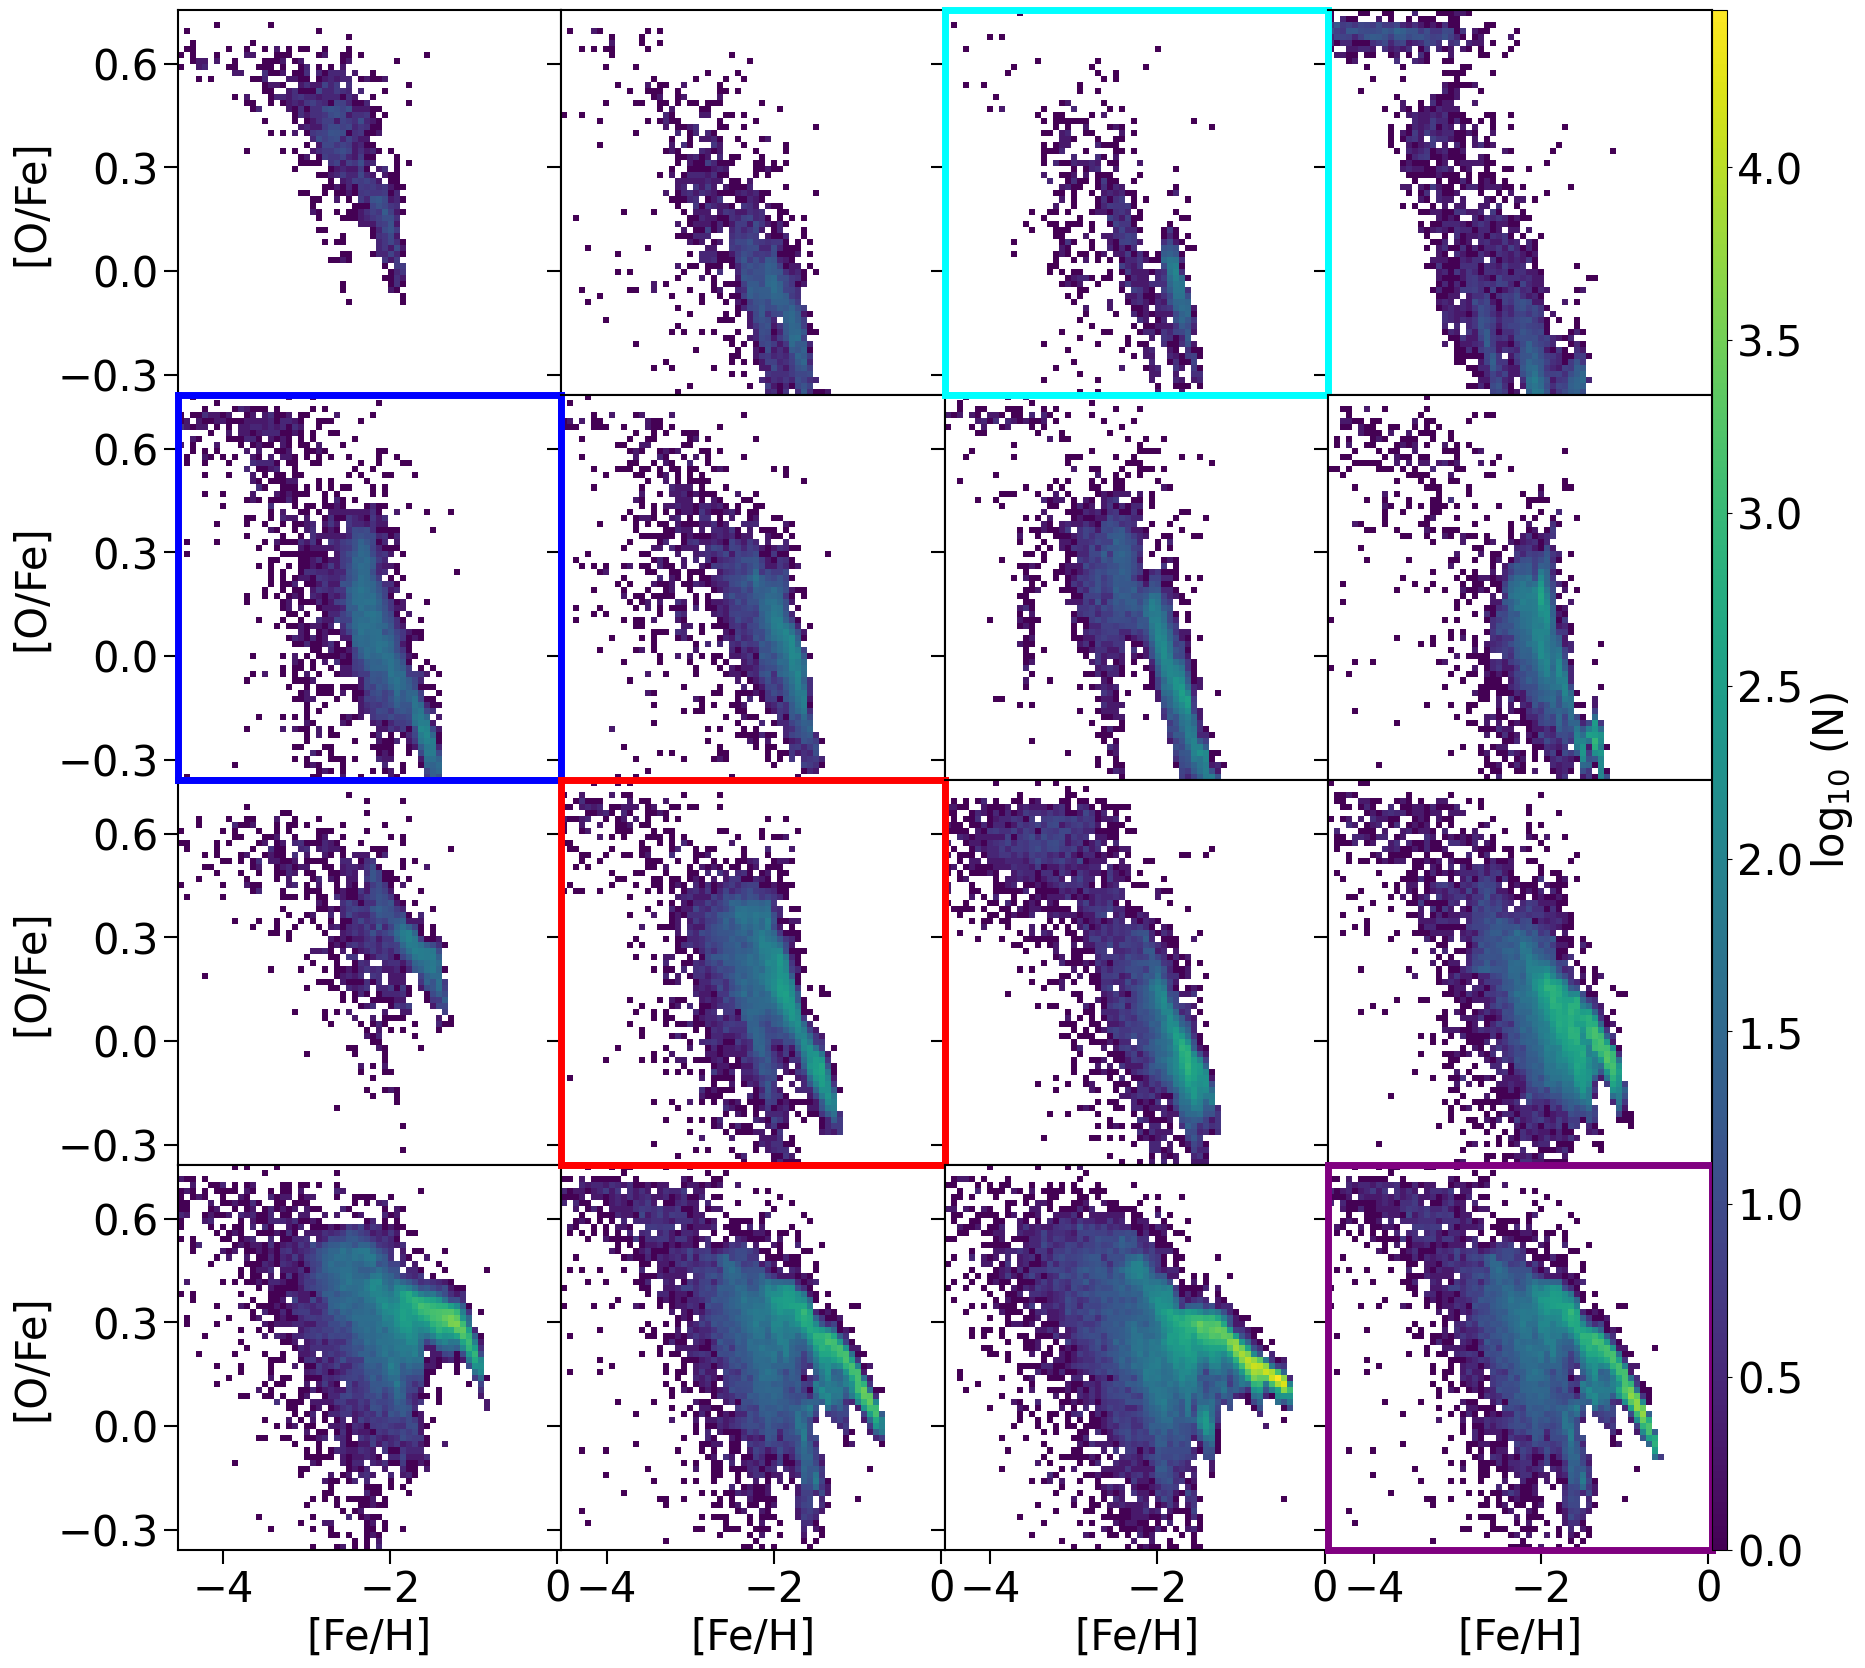

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator  # Make sure to import MaxNLocator

string_size = 30

fig, axs = plt.subplots(4, 4, figsize=(20, 20), sharex=True, sharey=True)  # Subplots share axes

# Remove spaces between histograms
fig.subplots_adjust(wspace=0, hspace=0)

min_arr = 1000
max_arr = 0
for i in range(4):  # Iterate over rows
    for j in range(4):  # Iterate over columns
        galaxy_name = grid_df[i, j, 0]  # Access the Galaxy_name from grid_df
        arr = np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{galaxy_name}'+'.npz')['observables']
        if arr[arr != 0].min() < min_arr:
            min_arr = arr[arr != 0].min()
        if arr.max() > max_arr:
            max_arr = arr.max() 


for i in range(4):  # Iterate over rows
    for j in range(4):  # Iterate over columns
        galaxy_name = grid_df[i, j, 0]  # Access the Galaxy_name from grid_df
        arr = np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{galaxy_name}'+'.npz')['observables']
        # arr[arr != 0] = arr[arr != 0]
        im = axs[i, j].imshow(np.log10(arr.T), origin='lower', vmin=np.log10(min_arr), vmax=np.log10(max_arr) , extent=[feh_min, feh_max, ofe_min, ofe_max], aspect='auto', cmap='viridis')
        
        # Use MaxNLocator to limit the number of ticks
        axs[i, j].xaxis.set_major_locator(MaxNLocator(nbins=3))  # Adjust 'nbins' as needed for x-axis
        axs[i, j].yaxis.set_major_locator(MaxNLocator(nbins=4))  # Adjust 'nbins' as needed for y-axis
        
        # Increase tick size and tick label size
        axs[i, j].tick_params(axis='both', which='major', labelsize=string_size, length=10, width=1.5)  # Adjust sizes as needed
        axs[i, j].set_xlabel('[Fe/H]', fontsize=string_size)  # Adjust fontsize as needed
        axs[i, j].set_ylabel('[O/Fe]', fontsize=string_size)
        
        #make the spines more thick
        for spine in axs[i, j].spines.values():
            spine.set_linewidth(1.5)
        
        # Show ticks only on the bottom row and leftmost column
        if i < 3:  # Hide x-axis labels for all but bottom row
            axs[i, j].tick_params(labelbottom=False)
            
        if j > 0:  # Hide y-axis labels for all but leftmost column
            axs[i, j].tick_params(labelleft=False)
            axs[i, j].set_ylabel('')


# After the loop where you set up the histograms
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', fraction=0.01, pad=0, aspect=100)
cbar.set_label(r'$\text{log}_{10}$ (N)', size=string_size)  # Set the label for the colorbar
cbar.ax.tick_params(labelsize=string_size)  # Adjust fontsize of the colorbar ticks



# Define a list of colors that work well together
colors = ['cyan', 'blue', 'red', 'purple']

# List of subplot indices to modify, now including [0, 0]
subplot_indices = [(0, 2), (1, 0), (2, 1), (3, 3)]

# Loop through each subplot index and apply color and line width modifications
for i, (row, col) in enumerate(subplot_indices):
    ax = axs[row, col]
    color = colors[i % len(colors)]  # Cycle through the colors list
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(5)

    # For the subplot directly below, if it exists
    if row + 1 < axs.shape[0]:
        axs[row + 1, col].spines['top'].set_edgecolor(color)
        axs[row + 1, col].spines['top'].set_linewidth(5)

    # For the subplot directly to the right, if it exists
    if col + 1 < axs.shape[1]:
        axs[row, col + 1].spines['left'].set_edgecolor(color)
        axs[row, col + 1].spines['left'].set_linewidth(5)

plt.show()  # Display the plot

/tmp/ipykernel_3933606/3643726774.py:14: RuntimeWarning: divide by zero encountered in log10
  im = axs[i].imshow(np.log10(arr.T), origin='lower', extent=[feh_min, 0.1, ofe_min, 0.9], aspect='auto',  vmin=np.log10(min_arr), vmax=np.log10(max_arr))


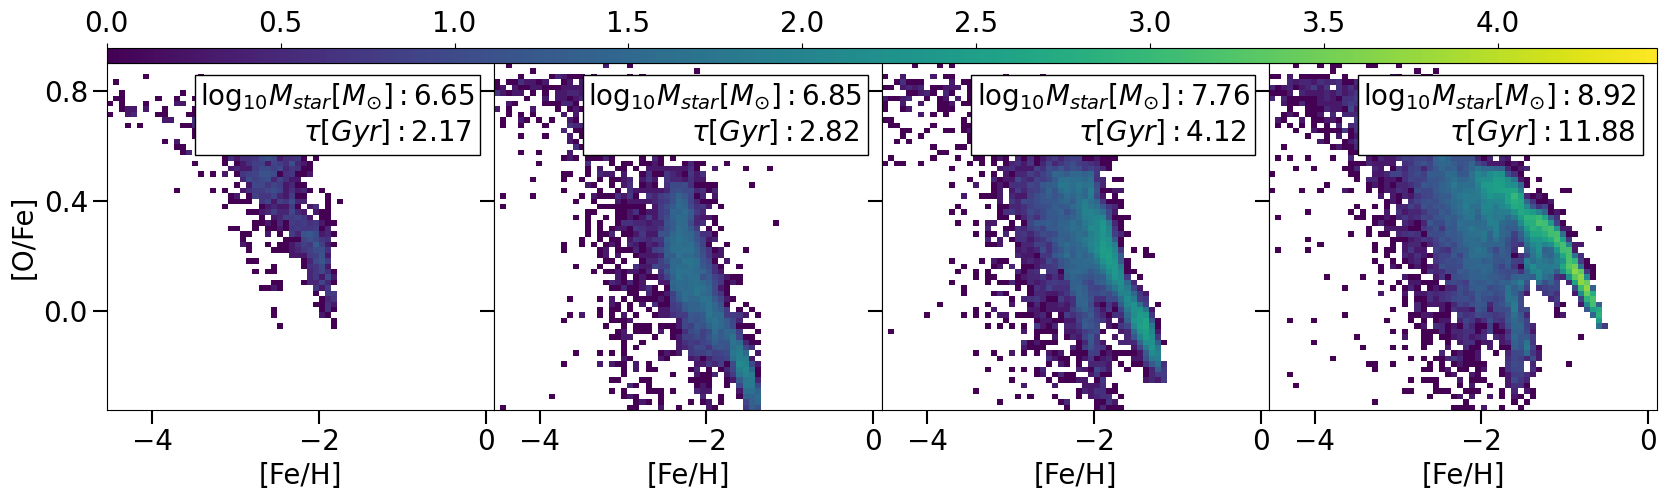

In [20]:
string_size = 20


fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)  # Subplots share axes

# Remove spaces between histograms
fig.subplots_adjust(wspace=0, hspace=0.01)

subplot_indices = [(0, 0), (1, 0), (2, 1), (3, 3)]

for i, sub in enumerate(subplot_indices):  # Iterate over rows
        galaxy_name = grid_df[sub[0], sub[1], 0]  # Access the Galaxy_name from grid_df
        arr = np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{galaxy_name}'+'.npz')['observables']
        im = axs[i].imshow(np.log10(arr.T), origin='lower', extent=[feh_min, 0.1, ofe_min, 0.9], aspect='auto',  vmin=np.log10(min_arr), vmax=np.log10(max_arr))
        
        
        # Use MaxNLocator to limit the number of ticks
        axs[i].xaxis.set_major_locator(MaxNLocator(nbins=3))  # Adjust 'nbins' as needed for x-axis
        axs[i].yaxis.set_major_locator(MaxNLocator(nbins=4))  # Adjust 'nbins' as needed for y-axis
        
        # Increase tick size and tick label size
        axs[i].tick_params(axis='both', which='major', labelsize=string_size, length=10, width=1.5)  # Adjust sizes as needed
        axs[i].set_xlabel('[Fe/H]', fontsize=string_size)  # Adjust fontsize as needed
        axs[i].set_ylabel('[O/Fe]', fontsize=string_size)
        
        text_to_plot=rf'log$_{{10}}M_{{star}} [M_{{\odot}}]:{np.log10(grid_df[sub[0], sub[1], 1]):.2f}$' + '\n' rf'$\tau [Gyr]:{grid_df[sub[0], sub[1], 2]:.2f}$ '
        axs[i].text(0.95, 0.95, text_to_plot, 
                transform=axs[i].transAxes, fontsize=string_size, verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=1, edgecolor='black'))
        
        # Show ticks only on the bottom row and leftmost column
        if i > 0:  # Hide x-axis labels for all but bottom row
            axs[i].set_ylabel('')
            
# After the loop where you set up the histograms
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', location='top', fraction=0.1, pad=0, aspect=100)
# cbar.set_label(r'$\text{log}_{10}$ (N)', size=string_size)  # Set the label for the colorbar
cbar.ax.tick_params(labelsize=string_size)  # Adjust fontsize of the colorbar ticks



# After the loop where you set up the histograms

# # Define a list of colors that work well together
# colors = ['cyan', 'blue', 'red', 'purple']

# # List of subplot indices to modify, now including [0, 0]

# for i, c in enumerate(colors):
#     for spine in axs[i].spines.values():
#         spine.set_edgecolor(c)
#         spine.set_linewidth(5)

plt.savefig('chemical_abbundance.pdf', bbox_inches='tight')

/tmp/ipykernel_1699327/412186246.py:14: RuntimeWarning: divide by zero encountered in log10
  im = axs.imshow(np.log10(arr.T), origin='lower', extent=[feh_min, feh_max, ofe_min, ofe_max], aspect='auto',  vmin=np.log10(min_arr), vmax=np.log10(max_arr))


Text(0, 0.5, '[O/Fe]')

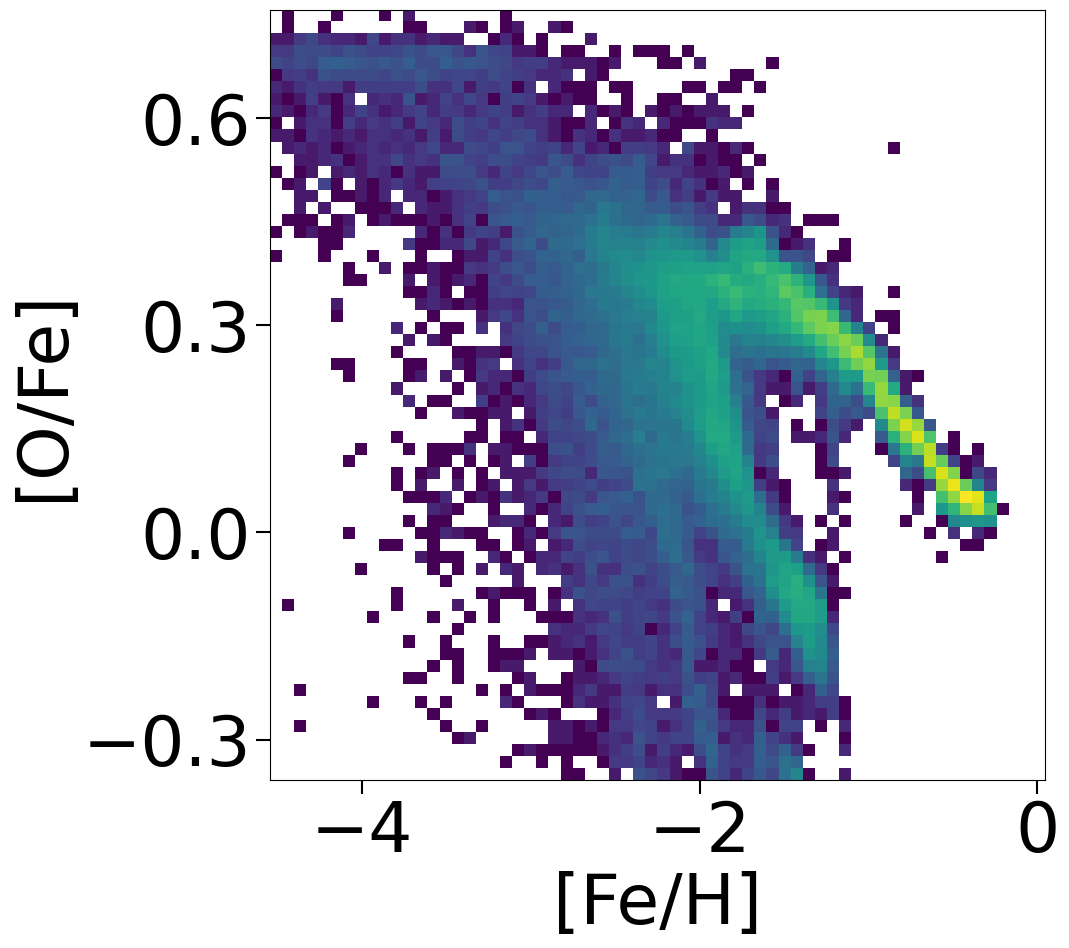

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)  # Subplots share axes

# Remove spaces between histograms
fig.subplots_adjust(wspace=0, hspace=0.01)

subplot_indices = [(0, 2), (1, 0), (2, 1), (3, 3)]
for i, sub in enumerate(subplot_indices):  # Iterate over rows
        galaxy_name = grid_df[sub[0], sub[1], 0]  # Access the Galaxy_name from grid_df
        if i==0:
                arr = np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{galaxy_name}'+'.npz')['observables']
        else:
                arr += np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{galaxy_name}'+'.npz')['observables']
                
im = axs.imshow(np.log10(arr.T), origin='lower', extent=[feh_min, feh_max, ofe_min, ofe_max], aspect='auto',  vmin=np.log10(min_arr), vmax=np.log10(max_arr))

# Use MaxNLocator to limit the number of ticks
axs.xaxis.set_major_locator(MaxNLocator(nbins=3))  # Adjust 'nbins' as needed for x-axis
axs.yaxis.set_major_locator(MaxNLocator(nbins=4))  # Adjust 'nbins' as needed for y-axis

# Increase tick size and tick label size
axs.tick_params(axis='both', which='major', labelsize=string_size, length=10, width=1.5)  # Adjust sizes as needed
axs.set_xlabel('[Fe/H]', fontsize=string_size)  # Adjust fontsize as needed
axs.set_ylabel('[O/Fe]', fontsize=string_size)
        

